In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import torch
from transformers import Trainer

# Remove cached module
if 'models' in sys.modules:
    del sys.modules['models']
if 'data_loader' in sys.modules:
    del sys.modules['data_loader']

# Fresh imports
from data_loader import ANLIDataLoader
from models import TransformerNLI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.5.1
CUDA available: False
MPS available: True


In [2]:
# Load data
loader = ANLIDataLoader()
train_df, dev_df, test_df = loader.load_data()

# Prepare data
train_premises, train_hypotheses = loader.prepare_text_pairs(train_df)
dev_premises, dev_hypotheses = loader.prepare_text_pairs(dev_df)
train_labels = train_df['label'].values
dev_labels = dev_df['label'].values

print(f"\nTrain samples: {len(train_labels)}")
print(f"Dev samples: {len(dev_labels)}")

Loading ANLI dataset:
Train size: 45460
Dev size: 1000
Test size: 1000

Train samples: 45460
Dev samples: 1000


## BERT Models

In [3]:
import os
os.environ['WANDB_DISABLED'] = 'true'
from transformers import Trainer, EarlyStoppingCallback

# Results tracking
all_results = []

# Models to train
models_config = [
    ('bert-base-uncased', 'BERT', '../models/bert_anli'),
    ('roberta-base', 'RoBERTa', '../models/roberta_anli'),
    ('microsoft/deberta-v3-base', 'DeBERTa-v3', '../models/deberta_anli'),
]

In [ ]:
for model_name, display_name, output_dir in models_config:
    print("\n" + "="*60)
    print(f"TRAINING {display_name.upper()} MODEL")
    print("="*60)

    # Load model
    model = TransformerNLI(model_name=model_name, num_labels=3)
    print(f"\nModel loaded on: {model.device}")

    # Tokenize data
    print("\nTokenizing data...")
    train_encodings = model.tokenize_data(
        train_premises,
        train_hypotheses,
        train_labels,
        max_length=128
    )
    dev_encodings = model.tokenize_data(
        dev_premises,
        dev_hypotheses,
        dev_labels,
        max_length=128
    )
    print(" Tokenization complete")

    # Create datasets
    train_dataset = model.create_dataset(train_encodings)
    dev_dataset = model.create_dataset(dev_encodings)
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Dev dataset size: {len(dev_dataset)}")

    # Training arguments
    training_args = model.get_training_args(
        output_dir=output_dir,
        num_epochs=5,  # More epochs with early stopping
        batch_size=16,
        learning_rate=2e-5
    )
    training_args.report_to = []  # Disable wandb

    print("Training configuration:")
    print(f"  Epochs: {training_args.num_train_epochs}")
    print(f"  Batch size: {training_args.per_device_train_batch_size}")
    print(f"  Learning rate: {training_args.learning_rate}")

    # Initialize trainer with early stopping
    trainer = Trainer(
        model=model.model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=model.compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print("✓ Trainer initialized")
    print(f"Model device: {model.device}")
    print(f"Trainer device: {trainer.model.device}")

    # Train model
    print(f"\nStarting {display_name} training...")
    print("Training with early stopping (patience=2)...\n")

    trainer.train()

    print(f"\n✓ {display_name} training complete!")

    # Evaluate on dev set
    print(f"\nEvaluating {display_name} on dev set...")
    eval_results = trainer.evaluate()

    print(f"\n{display_name} Dev Results:")
    for key, value in eval_results.items():
        print(f"  {key}: {value:.4f}")

    # Save model
    model.model.save_pretrained(f'{output_dir}/final')
    model.tokenizer.save_pretrained(f'{output_dir}/final')
    print(f"\n✓ Model saved to {output_dir}/final")

    # Store results
    all_results.append({
        'Model': display_name,
        'Model Name': model_name,
        'Dev Accuracy': eval_results['eval_accuracy'],
        'Dev F1': eval_results['eval_f1'],
        'Dev Loss': eval_results['eval_loss']
    })

    print(f"\n{'='*60}")
    print(f"✅ {display_name} COMPLETED!")
    print(f"{'='*60}\n")


TRAINING BERT MODEL


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using NVIDIA GPU (CUDA)

Model loaded on: cuda

Tokenizing data...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✓ Tokenization complete
Train dataset size: 45460
Dev dataset size: 1000
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
✓ Trainer initialized
Model device: cuda
Trainer device: cuda:0

Starting BERT training...
Training with early stopping (patience=2)...



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.549000,1.466134,0.429000,0.416222
2,0.354900,1.651698,0.448000,0.431544
3,0.279900,1.906986,0.465000,0.461910



✓ BERT training complete!

Evaluating BERT on dev set...



BERT Dev Results:
  eval_loss: 1.4661
  eval_accuracy: 0.4290
  eval_f1: 0.4162
  eval_runtime: 7.4452
  eval_samples_per_second: 134.3150
  eval_steps_per_second: 8.4620
  epoch: 3.0000

✓ Model saved to ../models/bert_anli/final

✅ BERT COMPLETED!


TRAINING ROBERTA MODEL


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using NVIDIA GPU (CUDA)

Model loaded on: cuda

Tokenizing data...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✓ Tokenization complete
Train dataset size: 45460
Dev dataset size: 1000
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
✓ Trainer initialized
Model device: cuda
Trainer device: cuda:0

Starting RoBERTa training...
Training with early stopping (patience=2)...



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.508900,1.720267,0.415000,0.404229
2,0.329600,1.637181,0.442000,0.430613
3,0.318100,1.795097,0.450000,0.447281
4,0.219700,2.575842,0.473000,0.467319



✓ RoBERTa training complete!

Evaluating RoBERTa on dev set...



RoBERTa Dev Results:
  eval_loss: 1.6372
  eval_accuracy: 0.4420
  eval_f1: 0.4306
  eval_runtime: 7.1348
  eval_samples_per_second: 140.1590
  eval_steps_per_second: 8.8300
  epoch: 4.0000

✓ Model saved to ../models/roberta_anli/final

✅ RoBERTa COMPLETED!


TRAINING DEBERTA-V3 MODEL


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using NVIDIA GPU (CUDA)

Model loaded on: cuda

Tokenizing data...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✓ Tokenization complete
Train dataset size: 45460
Dev dataset size: 1000
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
✓ Trainer initialized
Model device: cuda
Trainer device: cuda:0

Starting DeBERTa-v3 training...
Training with early stopping (patience=2)...



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.410500,1.525667,0.453000,0.443881
2,0.253000,1.733601,0.488000,0.484124
3,0.243200,2.031079,0.477000,0.475531



✓ DeBERTa-v3 training complete!

Evaluating DeBERTa-v3 on dev set...



DeBERTa-v3 Dev Results:
  eval_loss: 1.5257
  eval_accuracy: 0.4530
  eval_f1: 0.4439
  eval_runtime: 9.8081
  eval_samples_per_second: 101.9570
  eval_steps_per_second: 6.4230
  epoch: 3.0000

✓ Model saved to ../models/deberta_anli/final

✅ DeBERTa-v3 COMPLETED!


TRAINING ELECTRA MODEL


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using NVIDIA GPU (CUDA)

Model loaded on: cuda

Tokenizing data...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✓ Tokenization complete
Train dataset size: 45460
Dev dataset size: 1000
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
✓ Trainer initialized
Model device: cuda
Trainer device: cuda:0

Starting ELECTRA training...
Training with early stopping (patience=2)...



Epoch,Training Loss,Validation Loss



FINAL MODEL COMPARISON

      Model                Model Name  Dev Accuracy  Dev F1  Dev Loss
DeBERTa-v3 microsoft/deberta-v3-base         0.453  0.4439    1.5257
   RoBERTa              roberta-base         0.442  0.4306    1.6372
      BERT         bert-base-uncased         0.429  0.4162    1.4661

✓ Results saved to ../results/all_models_comparison.csv


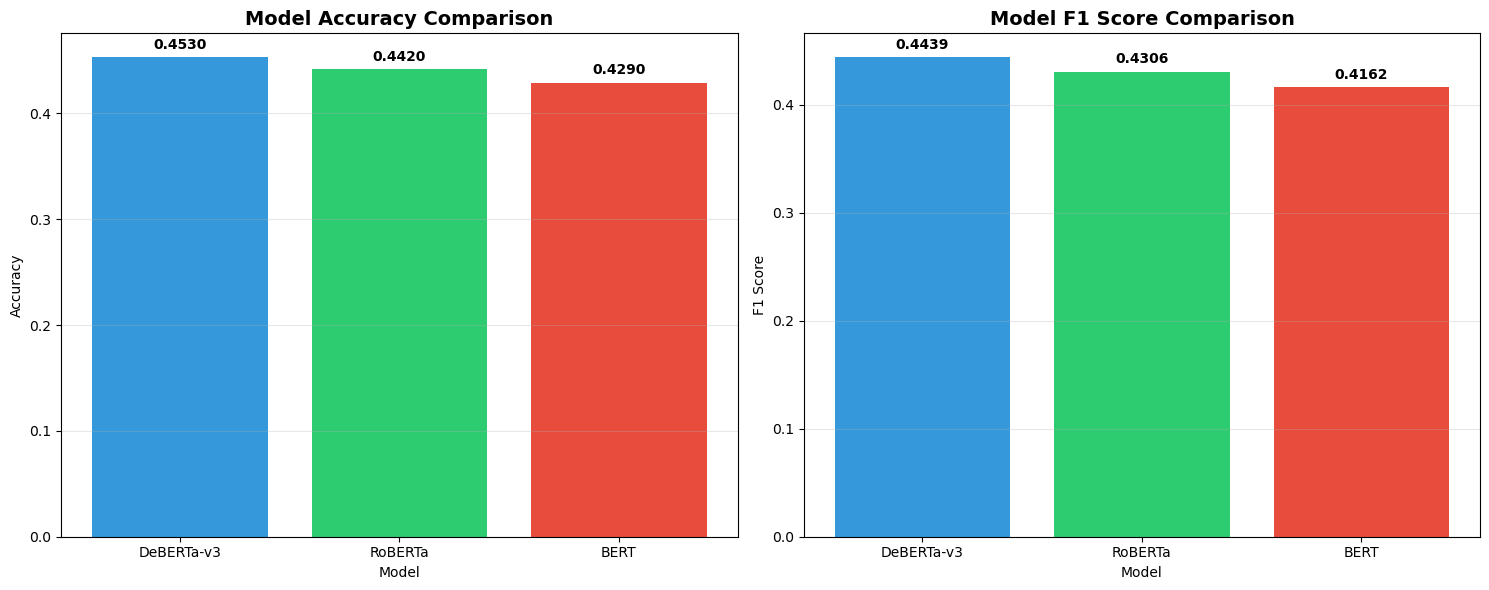


✓ Comparison plot saved to ../results/all_models_comparison.png

🏆 BEST MODEL: DeBERTa-v3
   Accuracy: 0.4530
   F1 Score: 0.4439

ALL TRAINING COMPLETE!

Total models trained: 3
Best performing model: DeBERTa-v3

Next step: Run evaluation notebook with the best model!


In [ ]:
print("\n" + "="*60)
print(" MODEL COMPARISON")
print("="*60)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Dev Accuracy', ascending=False)

print("\n", results_df.to_string(index=False))

# Save comparison
results_df.to_csv('../results/all_models_comparison.csv', index=False)
print("\n Results saved to ../results/all_models_comparison.csv")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Dev Accuracy'],
            color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['Dev Accuracy']):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# F1 comparison
axes[1].bar(results_df['Model'], results_df['Dev F1'],
            color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['Dev F1']):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Comparison plot saved to ../results/all_models_comparison.png")

# Find best model
best_model = results_df.iloc[0]
print(f"\n BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Dev Accuracy']:.4f}")
print(f"   F1 Score: {best_model['Dev F1']:.4f}")

print("\n" + "="*60)
print("ALL TRAINING COMPLETE!")
print("="*60)
print(f"\nTotal models trained: {len(all_results)}")
print(f"Best performing model: {best_model['Model']}")
print("\nNext step: Run evaluation notebook with the best model!")

## Model Comparison

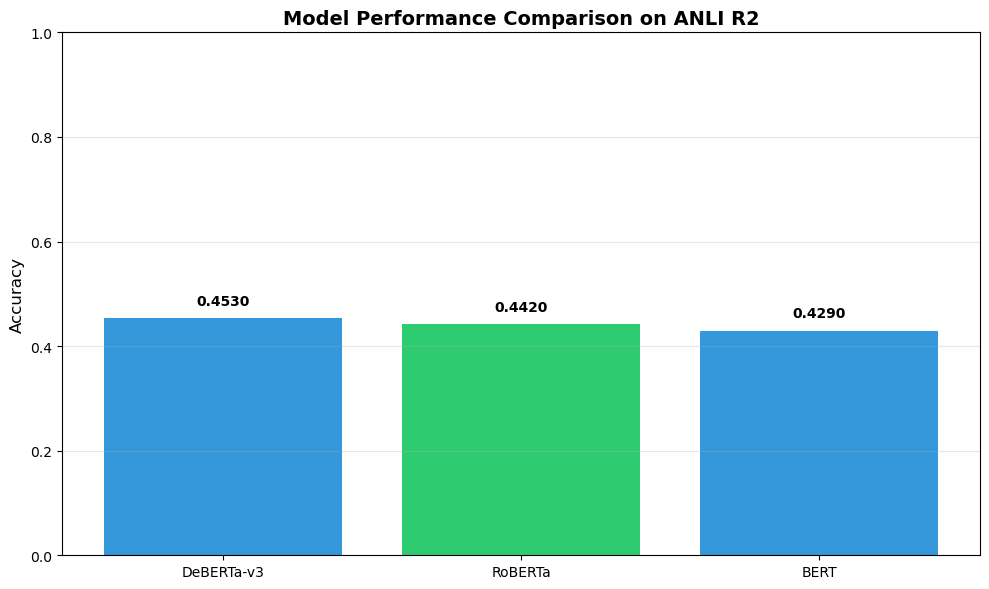

✓ Comparison plot saved


In [12]:
# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Dev Accuracy'], color=['#3498db', '#2ecc71'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison on ANLI R2', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['Dev Accuracy']):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved")